# Efficient Frontiner from Modern Portfolio Theory implemented in Python

Modern Portfolio Theory (MPT) is an investment theory developed by Harry Markowitz and published under the title "Portfolio Selection" in the Journal of Finance in 1952.

There are a few underlying concepts that can help anyone to understand MPT. If you are familiar with finance, you might know what the acronym "TANSTAAFL" stands for. It is a famous acronym for "There Ain't No Such Thing As A Free Lunch". This concept is also closely related to 'risk-return trade-off'.

Higher risk is associated with greater probability of higher return and lower risk with a greater probability of smaller return. MPT assumes that investors are risk-averse, meaning that given two portfolios that offer the same expected return, investors will prefer the less risky one. Thus, an investor will take on increased risk only if compensated by higher expected returns. 

Reference: http://projanco.com/Library/Project%20portfolio%20management.pdf

Another factor comes in to play in MPT is "diversification". Modern portfolio theory says that it is not enough to look at the expected risk and return of one particular stock. By investing in more than one stock, an investor can reap the benefits of diversification – chief among them, a reduction in the riskiness of the portfolio.

What you need to understand is "risk of a portfolio is not equal to average/weighted-average of individual stocks in the portfolio". In terms of return, yes it is the average/weighted average of individual stock's returns, but that's not the case for risk. The risk is about how volatile the asset is, if you have more than one stock in your portfolio, then you have to take count of how these stocks movement correlates with each other. The beauty of diversification is that you can even get lower risk than a stock with the lowest risk in your portfolio, by optimising the allocation. 

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In order to run the below code block, you will need your own API key. The stocks selected for this post is Apple, Amazon, Google, Facebook. Below code block will get daily adjusted closing price of each stock from 01/01/2016 to 31/12/2017.

In [2]:
from pandas_datareader import data 
import matplotlib.pyplot as plt 

import pandas as pd
# import numpy as np
# from scipy.stats import norm 
# import pyfolio as pf 

# from matplotlib.ticker import FuncFormatter
# %matplotlib inline

In [7]:
# to be declared**
start_date = '2018-01-01'
end_date = '2020-12-31'
tickers= ['AAPL', 'AMZN', 'GOOGL', 'FB']

# declare empty df to input data afterwhich;
panel_data= pd.DataFrame()

In [8]:
for t in tickers:
    
    t_data = data.DataReader(t,'yahoo', start_date, end_date) 
    
#     Use loc** method to ensure we do not consider extra days of data 
    t_data = t_data.loc[start_date: end_date]
    t_data = t_data[['Adj Close']]
    
#     t_data.columns= t_data.columns.droplevel()
    t_data= t_data.reset_index()
    t_data["ticker"]= t
    t_data= t_data.rename(columns={"Date": "date", t_data.columns[1]: "adj_close"})
#     print(t_data)
    panel_data= panel_data.append(t_data)

panel_data.head()

RemoteDataError: ignored

In [ ]:
# panel_data
# panel_data.to_csv(r'export.csv', index=False)

By looking at the info() of data, it seems like the "date" column is already in datetime format.

In [ ]:
panel_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2012 entries, 0 to 502
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       2012 non-null   datetime64[ns]
 1   adj_close  2012 non-null   float64       
 2   ticker     2012 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 62.9+ KB


In [ ]:
df = panel_data.set_index('date')
df.head()

,adj_close,ticker
date,,
2016-01-04,24.286831,AAPL
2016-01-05,23.678219,AAPL
2016-01-06,23.214846,AAPL
2016-01-07,22.235065,AAPL
2016-01-08,22.352642,AAPL


In [ ]:
table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,AAPL,AMZN,FB,GOOGL
date,,,,
2016-01-04,24.286831,636.989990,102.220001,759.440002
2016-01-05,23.678219,633.789978,102.730003,761.530029
2016-01-06,23.214846,632.650024,102.970001,759.330017
2016-01-07,22.235065,607.940002,97.919998,741.000000
2016-01-08,22.352642,607.049988,97.330002,730.909973


Let's first look at how the price of each stock has evolved within give time frame.

C:\Users\huajuan.tan.2019\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\huajuan.tan.2019\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\huajuan.tan.2019\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'price in $')

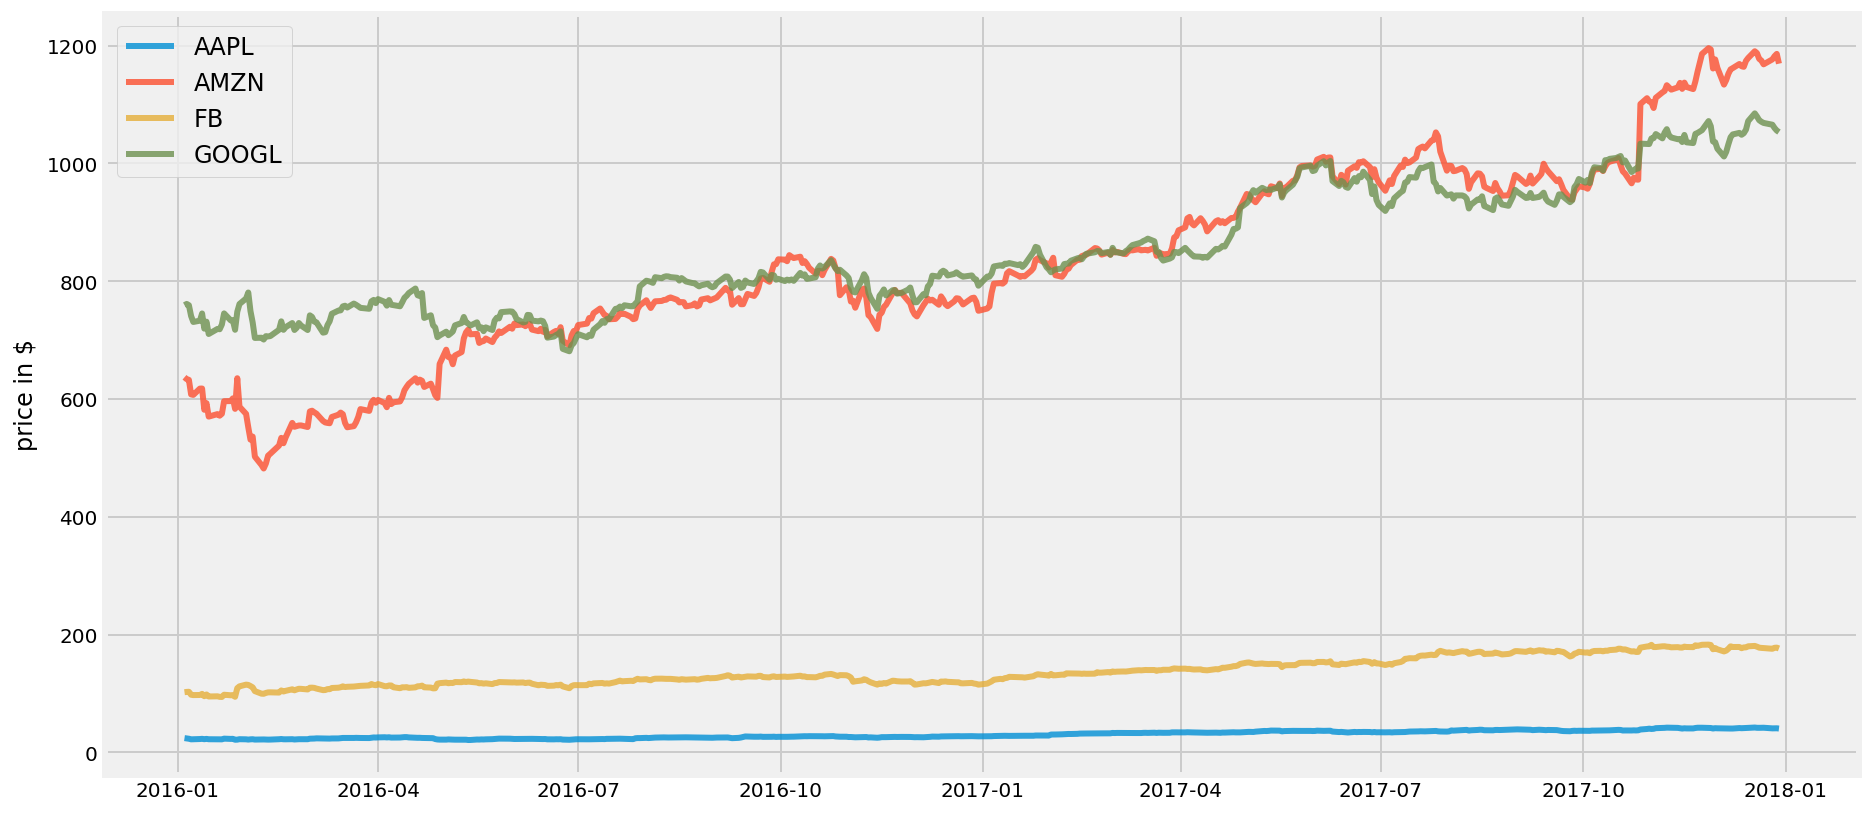

In [ ]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

It looks like that Amazon and Google's stock price is relatively more expensive than those of Facebook and Apple. But since Facebook and Apple are squashed at the bottom, it is hard to see the movement of these two.

Another way to plot this is plotting daily returns (percent change compared to the day before). By plotting daily returns instead of actual prices, we can see the stocks' volatility.

Text(0, 0.5, 'daily returns')

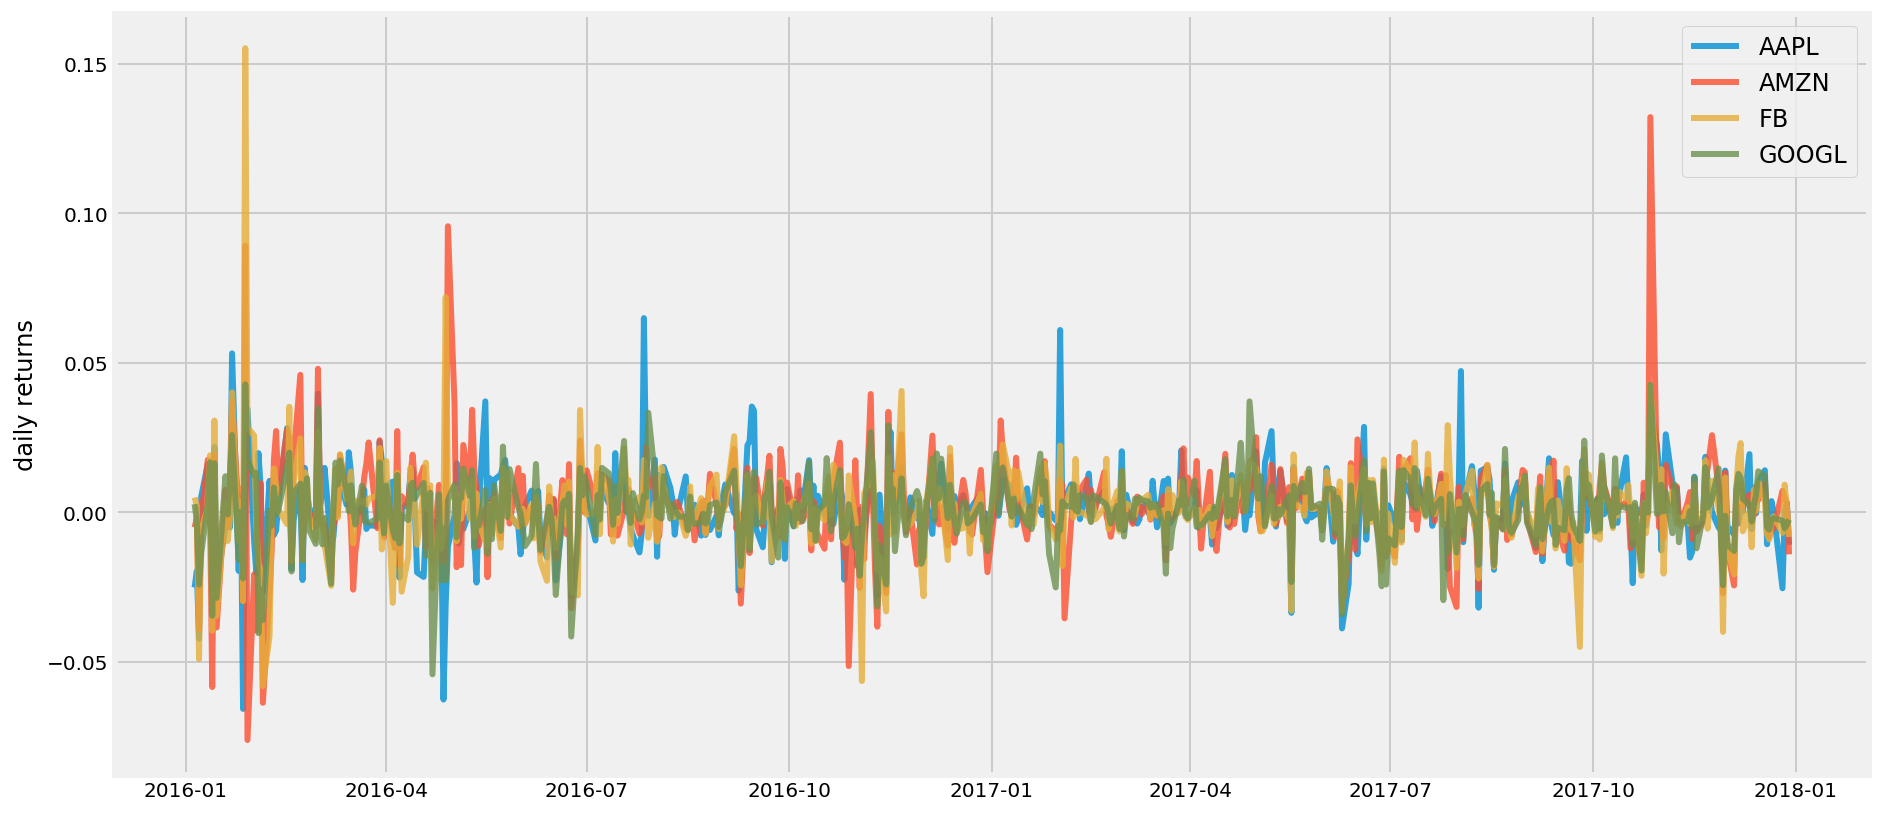

In [ ]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

Amazon has two distinctive positive spikes and a couple of negative ones. Facebook has one highest positive spike. And Google seems to be the least volatile.

## Random Portfolios Generation

We have 4 stocks in our portfolio. One decision we have to make is how we should allocate our budget to each of stock in our portfolio. If our total budget is 1, then we can decide the weights for each stock, so that the sum of weights will be 1. And the value for weights will be the portion of budget we allocate to a specific stock. For example, if weight is 0.5 for Amazon, it means that we allocate 50% of our budget to Amazon.

Let's define some functions to simulate random weights to each stock in the portfolio, then calculate the portfolio's overall annualised returns and annualised volatility.

"portfolio_annual_performance" function will calculate the returns and volatility, and to make it as an annualised calculation I take into account 252 as the number of trading days in one year. "random_portfolios" function will generate portfolios with random weights assigned to each stock, and by passing num_portfolios argument, you can decide how many random portfolios you want to generate.

In [ ]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

You can easily get daily returns by calling pct_change on the data frame with the price data. And the mean daily returns, the covariance matrix of returns are needed to calculate portfolio returns and volatility. Finally, let's generate 25,000 portfolios with random weights assigned to each stock.

In [ ]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
# num_portfolios = 25000
risk_free_rate = 0.0178

## Efficient Frontier

From the plot of the randomly simulated portfolio, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. Why is it efficient? Because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there's an option with lower risk?

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return). We can also implement this by using Scipy's optimize function.

If you are an advanced Excel user, you might be familiar with 'solver' function in excel. Scipy's optimize function is doing the similar task when given what to optimize, and what are constraints and bounds.

Below functions are to get the maximum Sharpe ratio portfolio. In Scipy's optimize function, there's no 'maximize', so as an objective function you need to pass something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. In "max_sharpe_ratio" function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, "weights"). At first, the construction of constraints was a bit difficult for me to understand, due to the way it is stated. 

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the 'fun' part construction as '1' on the right side of equal sign has been moved to the left side of the equal sign.

'np.sum(x) == 1' has become 'np.sum(x)-1'

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

"bounds" is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [ ]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

We can also define the optimizing function for calculating minimum volatility portfolio. This time we really do minimize the objective function. What do we want to minimize? We want to minimize volatility by trying different weights. "constraints" and "bounds" are same as the above.

In [ ]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

As I already mentioned above we can also draw a line which depicts where the efficient portfolios for a given risk rate should be. This is called "efficient frontier". Below I define other functions to compute efficient frontier. The first function "efficient_return" is calculating the most efficient portfolio for a given target return, and the second function "efficient_frontier" will take a range of target returns and compute efficient portfolio for each return level.

In [ ]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Instead of plotting every randomly generated portfolio, we can plot each individual stocks on the plot with the corresponding values of each stock's annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation.

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


             AAPL   AMZN     FB  GOOGL
allocation  45.28  28.85  25.88    0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.16


            AAPL  AMZN    FB  GOOGL
allocation  34.2  0.73  6.98  58.09
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AAPL : annuaised return 0.28 , annualised volatility: 0.21
AMZN : annuaised return 0.34 , annualised volatility: 0.25
FB : annuaised return 0.3 , annualised volatility: 0.23
GOOGL : annuaised return 0.18 , annualised volatility: 0.18
--------------------------------------------------------------------------------


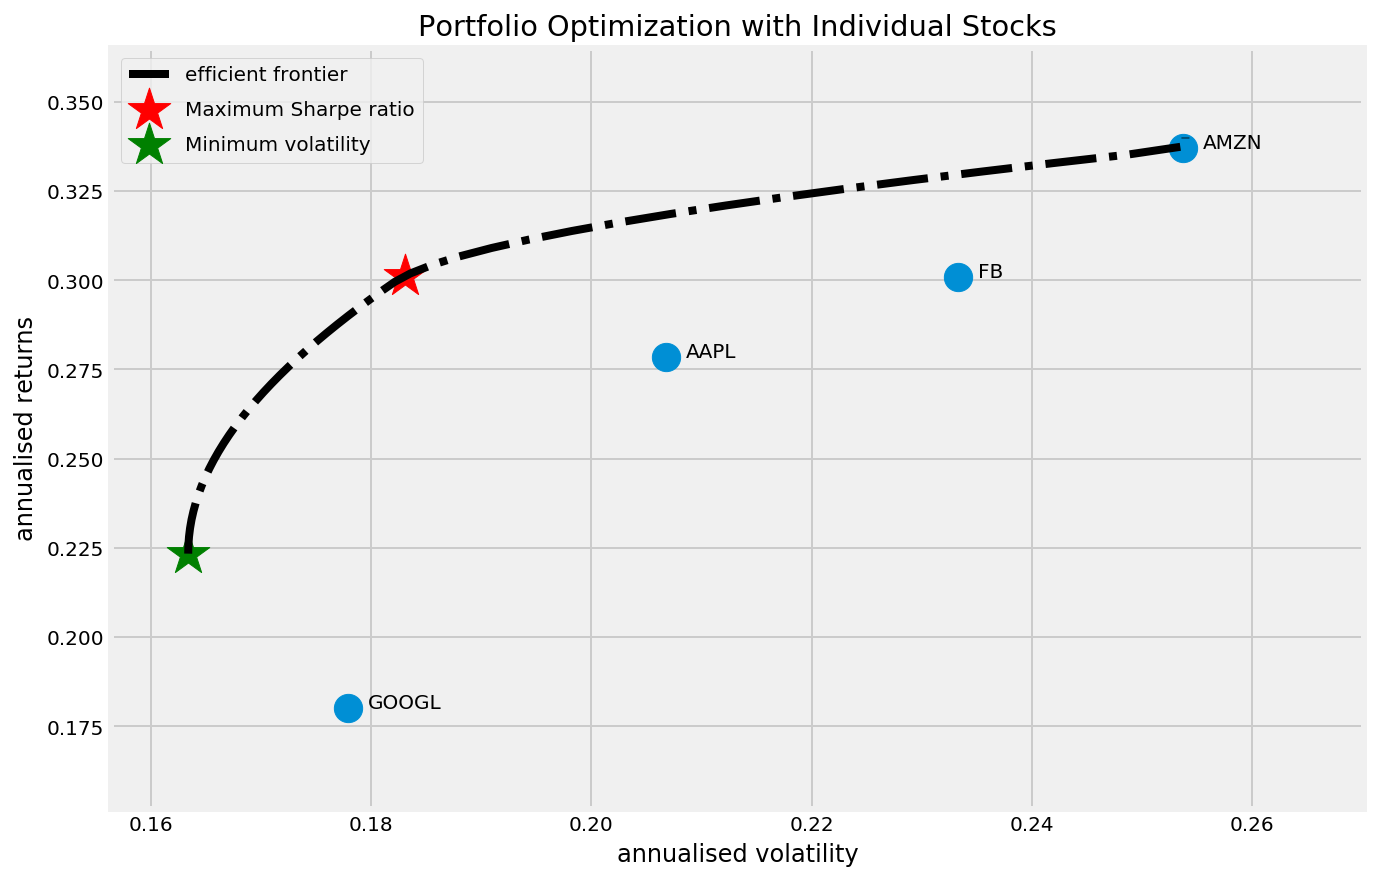

In [ ]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
    
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

As you can see from the above plot, the stock with the least risk is Google at around 0.18. But with portfolio optimisation, we can achieve even lower risk at 0.16, and still with a higher return than Google. And if we are willing to take slightly more risk at around the similar level of risk of Google, we can achieve a much higher return of 0.30 with portfolio optimization.